## Import Libraries

In [1]:
!pip install statsmodels
!pip install seaborn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline

import os
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import random

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import check_random_state
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn import metrics
from skimage import exposure
from scipy import ndimage

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential, Model

import functions_metrics as fm
import function_model_definition as md
import functions_read_data as rdat

print("TF  Version",tf.__version__)

TF  Version 2.4.0


In [3]:
# tf.config.experimental.get_memory_usage("GPU:0")

## Load Data 


In [4]:
# Define the path + output path:
print(os.getcwd())
DIR = "/tf/notebooks/"
IMG_DIR = "/tf/notebooks/hezo/stroke_zurich/data/" 
# IMG_DIR2 = "/tf/notebooks/kook/data-sets/stroke-lh/"
DATA_DIR = "/tf/notebooks/hezo/stroke_zurich/data/" 
OUTPUT_DIR = "/tf/notebooks/brdd/xAI_stroke_3d/weights/"


/tf/notebooks/brdd/xAI_stroke_3d


In [5]:
which_split = 1
# model_name = "3d_cnn_binary_model_split6_unnormalized_flatten_layer_paper_model_{epoch:03d}.h5"
model_name = "3d_cnn_binary_model_split" + str(which_split) + "_unnormalized_avg_layer_paper_model_sigmoid_activation_14.h5"
train= True

layer_connection = "globalAveragePooling"
last_activation = "sigmoid"

In [6]:
(X_train, X_valid, X_test), (y_train, y_valid, y_test), results = rdat.read_and_split_img_data(
    path_img = IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5', 
    path_tab = IMG_DIR + 'baseline_data_zurich_prepared.csv', 
    path_splits = '/tf/notebooks/brdd/xAI_stroke_3d/data/andrea_splits.csv', 
    split = which_split, 
    check_print = True)

image shape in:  (439, 128, 128, 28, 1)
image min, max, mean, std:  -0.7314910890799393 26.423200798592248 -4.100563400421584e-18 1.0
tabular shape in:  (507, 16)
split file shape in:  (407, 3)
X tab out shape:  (407, 13)
Y mrs out shape:  (407,)
End shapes X (train, val, test):  (325, 128, 128, 28) (41, 128, 128, 28) (41, 128, 128, 28)
End shapes y (train, val, test):  (325,) (41,) (41,)


In [7]:
print(np.mean(y_train))
print(np.mean(y_valid))
print(np.mean(y_test))

0.19692307692307692
0.17073170731707318
0.0975609756097561


## 3D Data Augmentation

In [8]:
# #augmentation functions

# @tf.function
# def rotate(volume):
#     """Rotate the volume by a few degrees"""

#     def scipy_rotate(volume):
#         # define some rotation angles
#         angles = [-20, -10, -5, 5, 10, 20]
#         # pick angles at random
#         angle = random.choice(angles)
#         # rotate volume
#         volume = ndimage.rotate(volume, angle, mode='nearest', reshape=False)
# #         volume[volume < 0] = 0
# #         volume[volume > 1] = 1
#         return volume

#     augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
#     return augmented_volume


# @tf.function
# def zoom(volume):
#     """Rotate the volume by a few degrees"""

#     def random_zoom3d(X_im, min_zoom = 0.85 , max_zoom = 1.15):
#         z = np.random.sample() *(max_zoom-min_zoom) + min_zoom
#         zoom_matrix = np.array([[z, 0, 0, 0],
#                             [0, z, 0, 0],
#                             [0, 0, z, 0],
#                             [0, 0, 0, 1]])
#         volume = ndimage.affine_transform(X_im, zoom_matrix, mode = "nearest", order = 1)
#         return volume

#     augmented_volume = tf.numpy_function(random_zoom3d, [volume], tf.float32)
#     return augmented_volume


# @tf.function
# def gauss(volume):
#     """Add some noise and smooth it with a gaussian filter"""

#     def random_gaussianfilter3d(X_im, sigma_max=0.2):
#         sigma = np.random.uniform(0, sigma_max)
#         volume = ndimage.gaussian_filter(X_im, sigma, mode = "nearest")
#         return volume

#     augmented_volume = tf.numpy_function(random_gaussianfilter3d, [volume], tf.float32)
#     return augmented_volume


# def train_preprocessing(volume, label):
#     """Process training data by rotating and adding a channel."""
#     # Rotate volume
#     volume = rotate(volume)
#     volume = zoom(volume)
# #     volume = gauss(volume)
#     volume = tf.expand_dims(volume, axis=3)
#     return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label



## Model

In [9]:
input_dim = np.expand_dims(X_train, axis = -1).shape[1:]
output_dim = 1

# call model
model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)
model_3d.summary()


Model: "cnn_3d_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 28, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 128, 128, 28, 32)  896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 64, 64, 14, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 64, 14, 32)    27680     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 32, 7, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 32, 32, 7, 64)     55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 16, 16, 3, 64)     0   

In [10]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

batch_size = 6

# Augment on the fly during training.
# train_dataset = (
#     train_loader.shuffle(len(X_train))
#     .map(train_preprocessing)
#     .batch(batch_size)
#     .prefetch(2)
# )

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.15,
    shear_range=0.15,
    fill_mode="nearest")
datagen.fit(X_train)

validation_dataset = (
    validation_loader.shuffle(len(X_valid))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

#compile
model_3d.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

# Define callbacks.
# checkpoint_cb = keras.callbacks.ModelCheckpoint(
#     OUTPUT_DIR + model_name, 
#     save_best_only=True
# )
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath = OUTPUT_DIR + "epochs/" + model_name,
    verbose = 1,
    save_weights_only = True,
    monitor = "val_loss", #'val_acc',
    mode = 'min',
    save_best_only = True)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True)


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (325, 128, 128, 28) (28 channels).
  ' channels).')


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (325, 128, 128, 28) (28 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


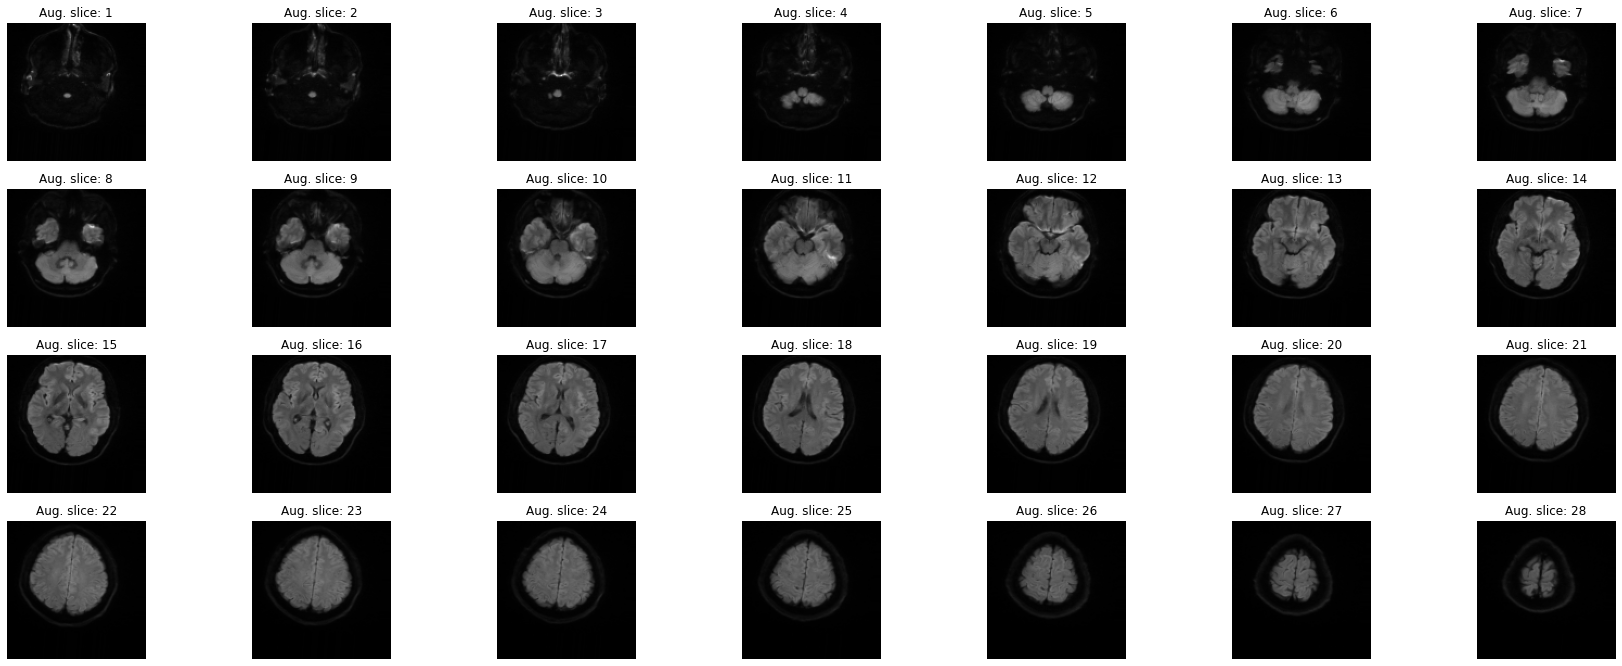

0

In [11]:
#Visualize Augemntation
# data = train_dataset.take(1)
# images, labels = list(data)[0]
# images = images.numpy()
data = datagen.flow(X_train, y_train, batch_size=batch_size)[0]
images, labels = data
image = images[0]

plt.figure(figsize=(30,30))
for i in range(image.shape[2]):
    plt.subplot(10,7,i+1)
    plt.imshow(np.squeeze(image[:, :, i]), cmap="gray", vmin = np.min(image), vmax = np.max(image))
#     plt.imshow(np.squeeze(image[:, i,: ]), cmap="gray")
    plt.axis('off')
    plt.title(str("Aug. slice: " + str(i+1)))
plt.show()

labels[0]

In [12]:
# Train the model, doing validation at the end of each epoch
epochs = 250

if train:
    hist = model_3d.fit(
        datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True),
        validation_data=validation_dataset,
        epochs=epochs,
        shuffle=True,
        verbose=1,
        callbacks=[checkpoint_cb, early_stopping_cb]
)  


Epoch 1/250
55/55 [==============================] - 36s 437ms/step - loss: 0.6019 - acc: 0.8024 - auc: 0.5035 - val_loss: 0.4597 - val_acc: 0.8293 - val_auc: 0.5210

Epoch 00001: val_loss improved from inf to 0.45975, saving model to /tf/notebooks/brdd/xAI_stroke_3d/weights/epochs/3d_cnn_binary_model_split1_unnormalized_avg_layer_paper_model_sigmoid_activation_14.h5
Epoch 2/250
55/55 [==============================] - 7s 134ms/step - loss: 0.5136 - acc: 0.8032 - auc: 0.4784 - val_loss: 0.4559 - val_acc: 0.8293 - val_auc: 0.5609

Epoch 00002: val_loss improved from 0.45975 to 0.45593, saving model to /tf/notebooks/brdd/xAI_stroke_3d/weights/epochs/3d_cnn_binary_model_split1_unnormalized_avg_layer_paper_model_sigmoid_activation_14.h5
Epoch 3/250
55/55 [==============================] - 8s 136ms/step - loss: 0.5406 - acc: 0.7985 - auc: 0.4370 - val_loss: 0.4574 - val_acc: 0.8293 - val_auc: 0.5567

Epoch 00003: val_loss did not improve from 0.45593
Epoch 4/250
55/55 [=====================

55/55 [==============================] - 7s 133ms/step - loss: 0.5480 - acc: 0.7787 - auc: 0.5238 - val_loss: 0.4493 - val_acc: 0.8293 - val_auc: 0.8151

Epoch 00030: val_loss did not improve from 0.44342
Epoch 31/250
55/55 [==============================] - 7s 133ms/step - loss: 0.4444 - acc: 0.8321 - auc: 0.5932 - val_loss: 0.4595 - val_acc: 0.8293 - val_auc: 0.7962

Epoch 00031: val_loss did not improve from 0.44342
Epoch 32/250
55/55 [==============================] - 7s 132ms/step - loss: 0.4969 - acc: 0.8065 - auc: 0.5229 - val_loss: 0.4487 - val_acc: 0.8293 - val_auc: 0.8130

Epoch 00032: val_loss did not improve from 0.44342
Epoch 33/250
55/55 [==============================] - 7s 129ms/step - loss: 0.5443 - acc: 0.7646 - auc: 0.5793 - val_loss: 0.4495 - val_acc: 0.8293 - val_auc: 0.8172

Epoch 00033: val_loss did not improve from 0.44342
Epoch 34/250
55/55 [==============================] - 7s 134ms/step - loss: 0.5093 - acc: 0.7900 - auc: 0.5605 - val_loss: 0.4587 - val_acc: 

55/55 [==============================] - 8s 139ms/step - loss: 0.4978 - acc: 0.7938 - auc: 0.5917 - val_loss: 0.4151 - val_acc: 0.8293 - val_auc: 0.8571

Epoch 00062: val_loss improved from 0.41671 to 0.41513, saving model to /tf/notebooks/brdd/xAI_stroke_3d/weights/epochs/3d_cnn_binary_model_split1_unnormalized_avg_layer_paper_model_sigmoid_activation_14.h5
Epoch 63/250
55/55 [==============================] - 7s 134ms/step - loss: 0.5505 - acc: 0.7614 - auc: 0.5616 - val_loss: 0.4152 - val_acc: 0.8293 - val_auc: 0.8613

Epoch 00063: val_loss did not improve from 0.41513
Epoch 64/250
55/55 [==============================] - 7s 133ms/step - loss: 0.5370 - acc: 0.7777 - auc: 0.5430 - val_loss: 0.4171 - val_acc: 0.8293 - val_auc: 0.8592

Epoch 00064: val_loss did not improve from 0.41513
Epoch 65/250
55/55 [==============================] - 7s 129ms/step - loss: 0.4658 - acc: 0.8194 - auc: 0.5816 - val_loss: 0.4429 - val_acc: 0.8293 - val_auc: 0.8676

Epoch 00065: val_loss did not improv

KeyboardInterrupt: 

In [ ]:
if train:
    plt.figure(figsize = (30,10))
    plt.subplot(1,3,1)
    plt.plot(hist.history['loss'], label = "loss")
    plt.plot(hist.history['val_loss'],label = "val_loss")
    plt.legend()
    plt.subplot(1,3,2)
    plt.plot(hist.history['acc'], label = "acc")
    plt.plot(hist.history['val_acc'],label = "val_acc")
    plt.legend()
    plt.subplot(1,3,3)
    plt.plot(hist.history['auc'], label = "auc")
    plt.plot(hist.history['val_auc'],label = "val_auc")
    plt.legend()
    plt.show()

In [ ]:
if train:
    epoch_index = 55
    print(hist.history["val_loss"][epoch_index])
    print(hist.history["val_acc"][epoch_index])
    print(hist.history["val_auc"][epoch_index])

## model evaluation

In [ ]:
if not train:
    model_3d.load_weights("weights/" + model_name)
if train:
    model_3d.load_weights("weights/epochs/" + model_name)
model_3d.evaluate(x=X_test, y=y_test)

In [ ]:
y_pred = model_3d.predict(X_test)
# y_pred

In [ ]:
# y_pred = fm.sigmoid(y_pred)
# y_pred

In [ ]:
# model_3d.load_weights("weights/" + model_name)
fm.bin_class_report(X_test, 
                 y_test, 
                 model = model_3d)

In [ ]:
y_pred = model_3d.predict(X_test)

fpr, tpr, threshold = metrics.roc_curve(y_test, (y_pred))
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
print(threshold[index])

In [ ]:
# acc
y_pred_label = (y_pred >= threshold[index]).squeeze()
np.mean(y_pred_label == y_test)

In [ ]:
# acc to beat
1 - np.mean(y_test)

In [ ]:
print("spezifität: ", 1-fpr[index])
print("sensitivität: ", tpr[index])

In [ ]:
results["pred_prob"] = y_pred.squeeze()

In [ ]:
import seaborn as sns

sns.boxplot(x = "unfavorable",
            y = "pred_prob",
            data = results)
sns.stripplot(x = "unfavorable",
              y = "pred_prob",
              color = 'blue',
              data = results)
plt.axhline(y = threshold[index], color = "red")

## Calibration Plots and Result Comparision

In [ ]:
y_pred = model_3d.predict(X_test)
y_pred = y_pred.squeeze()
print(np.min(y_pred), np.max(y_pred))

In [ ]:
cal_plot_data = fm.cal_plot_data_prep(y_pred, y_test)
cal_plot_data

In [ ]:
fm.cal_plot(cal_plot_data, "predicted_probability_middle", "observed_proportion",
                        "observed_proportion_lower", "observed_proportion_upper")

### Load Andreas Results

In [ ]:
andrea_result_path = "/tf/notebooks/kook/dtm-usz-stroke/intermediate-results/"
andrea_results_ens1 = pd.read_csv(
    andrea_result_path + 'raw-results/stroke_cimrsbinary_lossnll_wsno_augyes_cdftest_spl' + str(which_split) + '_ens1.csv'
    ).rename(columns={"Unnamed: 0": "p_idx"})
andrea_results_ens2 = pd.read_csv(
    andrea_result_path + 'raw-results/stroke_cimrsbinary_lossnll_wsno_augyes_cdftest_spl' + str(which_split) + '_ens2.csv'
    ).rename(columns={"Unnamed: 0": "p_idx"})
andrea_results_ens3 = pd.read_csv(
    andrea_result_path + 'raw-results/stroke_cimrsbinary_lossnll_wsno_augyes_cdftest_spl' + str(which_split) + '_ens3.csv'
    ).rename(columns={"Unnamed: 0": "p_idx"})
andrea_results_ens4 = pd.read_csv(
    andrea_result_path + 'raw-results/stroke_cimrsbinary_lossnll_wsno_augyes_cdftest_spl' + str(which_split) + '_ens4.csv'
    ).rename(columns={"Unnamed: 0": "p_idx"})
andrea_results_ens5 = pd.read_csv(
    andrea_result_path + 'raw-results/stroke_cimrsbinary_lossnll_wsno_augyes_cdftest_spl' + str(which_split) + '_ens5.csv'
    ).rename(columns={"Unnamed: 0": "p_idx"})

In [ ]:
results["andrea_pred_prob_ens1"] = 1-andrea_results_ens1["V2"]
results["andrea_pred_prob_ens2"] = 1-andrea_results_ens2["V2"]
results["andrea_pred_prob_ens3"] = 1-andrea_results_ens2["V2"]
results["andrea_pred_prob_ens4"] = 1-andrea_results_ens2["V2"]
results["andrea_pred_prob_ens5"] = 1-andrea_results_ens2["V2"]

results.head()

In [ ]:
np.mean(y_test)

### Compare Results

In [ ]:
g = sns.scatterplot(data=results, x="pred_prob", y="andrea_pred_prob_ens1", hue = "unfavorable")
plt.legend(loc='lower right')
g.set(ylim=(0, 1), xlim=(0,1))
g.plot([0,1], [0,1], "r--")

### Calipration Plot: all of Andrea vs. current split

In [ ]:
# andrea_calplot_dat = pd.read_csv('/tf/notebooks/brdd/xAI_stroke_3d/data/bincal_avgnll.csv')
andrea_calplot_dat = pd.read_csv(andrea_result_path + 'bincal_avgnll.csv')
andrea_calplot_cibinary_avg = andrea_calplot_dat[(andrea_calplot_dat["mod"] == "cimrsbinary") &
                                                 (andrea_calplot_dat["method"] == "trafo") &
                                                 (andrea_calplot_dat["weights"] == "equal")]
andrea_calplot_cibinary_avg
# cal_plot(andrea_calplot_cibinary_avg, "midpoint", "prop", "lwr", "upr")

In [ ]:
andrea_calplot_dat_spl = pd.read_csv('/tf/notebooks/brdd/xAI_stroke_3d/data/bincal_splnll.csv')
andrea_calplot_cibinary_spl = andrea_calplot_dat_spl[(andrea_calplot_dat_spl["mod"] == "cimrsbinary") &
                                                     (andrea_calplot_dat_spl["method"] == "trafo") &
                                                     (andrea_calplot_dat_spl["weights"] == "equal")]
andrea_calplot_cibinary_spl.head()

In [ ]:
# plt.figure(figsize=(4, 4))

for i in range(5):
    fm.cal_plot(andrea_calplot_cibinary_spl[andrea_calplot_cibinary_spl["spl"] == i], 
             "midpoint", "prop", "lwr", "upr", alpha = .35, show = False)
fm.cal_plot(andrea_calplot_cibinary_avg, "midpoint", "prop", "lwr", "upr", show = False)
fm.cal_plot(cal_plot_data, "predicted_probability_middle", "observed_proportion",
                        "observed_proportion_lower", "observed_proportion_upper", col = "orange")